# Hipocotile grow model 
From: DOI: 10.1126/sciadv.abp8412

$\frac{dB(t)}{dt}=p_{B}(T)\times L(t)\times(mut_{B}-B(t))-k_{r}(T)\times B(t)$

$\frac{dE(t)}{dt}=mut_{E}\times p_{E}\left(t,T,D\right)-d_{E}\times E(t)$

$\frac{dC(t)}{dt}=mut_{C}\left[p_{CL}(T)\times L(t)+p_{CD}\bigl(1-L(t)\bigr)\right]-d_{C}\times C(t)$

$\frac{dP(t)}{dt}=mut_{P}\frac{p_{P}}{1+p_{PE}(T)\times E(t)}-\frac{d_{P}}{1+k_{PC}\times C(t)}\times P(t)-d_{PB}\times B(t)\times P(t)$

$\frac{dG(t)}{dt}=p_{G}+k_{G}\frac{p_{GP} P(t)}{1 + p_{GP} P(t) + p_{GE} E(t) + p_{GB} B(t) + H(t)}; \space H(t)=\dfrac{mut_H\times p_{GH}}{1+p_{HC}\times C(t)}$

ELF3s expression follows a quasi-square wave:

$p_E(t,T,D) = 
\begin{cases} 
p_{E1}(T)+p_{E2}(T), & \text{if } D = 0 \text{ hours},\\[6pt]
p_{E1}(T) - p_{E2}(T) (-1+\dfrac{2}{1+\exp(-k_0 t_0)} - \dfrac{2}{1+\exp(-k_0 t_1)} + \dfrac{2}{1+\exp(-k_0 t_2)}), & \text{if } 0 < D < 24 \text{ hours},\\[8pt]
p_{E1}(T)-p_{E2}(T), & \text{if } D = 24 \text{ hours}.
\end{cases}$


## Importing modules

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import operator

## Value parameter generator
Value parameter generator on basis of Temperature and Mutant Classes

In [9]:
# Temperature dependent parameters (labeled as (22) o (28))
params_by_T = {
    22: dict(
        p_B = 10.0,
        k_r = 0.232,
        p_E1 = 108.0,
        p_E2 = 39.8,
        p_CL = 1.00,
        p_PE = 0.332,
    ),
    28: dict(
        p_B = 0.860,
        k_r = 0.411,
        p_E1 = 127.0,
        p_E2 = 7.29,
        p_CL = 5.37,
        p_PE = 0.028,
    ),
}


# Independent parameters 
common_params = dict(
    # Producción/deg y acoplamientos que no dependen de T según la tabla
    d_E = 27.2,
    p_CD = 112.0, 
    p_P = 1.0,    
    d_P = 4.91,

    p_G = 0.009,
    p_GP = 2.93,    
    p_GB = 10.7,    
    p_HC = 0.180,

    d_C  = 1.79,
    d_PB = 0.313,    
    k_PC = 34.3,
    k_G  = 0.113,   
    p_GE = 0.465,
    p_GH = 116.0,

    # (Resto de parámetros que no salen en la tabla: pon aquí tus defaults)
    d_BC = 0,    d_BP = 0,
    d_EC = 0,    k_EB = 0,
    d_CB = 0,    # H  = 1.0,
)


# Mutation efects
MUT_B = {"WT":1.0,      "phyB-9":0.0,       "PHYBox":65.0                       }
MUT_E = {"WT":1.0,      "elf3-8":0.0,       "ELF3ox":1.18                       }
MUT_C = {"WT":1.0,      "cop1-4":0.032,     "cop1-6":0.056,    "COP1-OE":499.0  }
MUT_P = {"WT":1.0,      "pif4":0.495,       "pifq":0.198,      "PIF4ox":6.37    }
MUT_H = {"WT":1.0,      "hy5":0.0  } # p_GH !!


# Parameter Constructor
def build_params(T=22, mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    if T not in params_by_T:
        raise ValueError("T debe ser 22 o 28.")
        
    # Fusiona: COMMON -> tabla(T)
    d = {**common_params, **params_by_T[T]}
    # Fija T
    d["T"] = float(T)
    # Aplica mutantes
    d["mut_B"] = MUT_B[mutB]
    d["mut_E"] = MUT_E[mutE]
    d["mut_C"] = MUT_C[mutC]
    d["mut_P"] = MUT_P[mutP]
    d["mut_H"] = MUT_H[mutH]

    return d

In [10]:
# Use Example

#P22 = build_params(T=22)                        # 22°C, WT
#P28 = build_params(T=28, mutE="ELF3ox")         # 28°C, ELF3ox
#P28_pifq = build_params(T=28, mutP="pifq")      # 28°C, pifq

Funciones del modelo de ODEs y luz:

In [ ]:
# =========================
# Light function ON/OFF
# =========================

def L_of_t(t, D):
    '''
    L(t): Light representation on the ODE system, it is either 0 at night, or 1 during daytime.

    Arguments
    ---------
    t      : time (h) – unused except for ODE signature
    D      : (daylength) light hours in the day

    Returns
    -------
    Calculus of expresion of ELF3s
    '''
    if (t % 24) < D:
        return 1.0
    else:
        return 0.0

# =========================
# ELF3 square-wave p_E(t)
# =========================

def pE_func(t, D, pE1, pE2, k0=5.0):
    '''
    p_E(t): ELF3s production that follows a quasi-square wave function (Nieto et al. 2022).

    Arguments
    ---------
    t      : time (h) – unused except for ODE signature
    D      : (daylength) light hours in the day
    pE1    : ELF3s production level 1
    pE2    : ELF3s production level 2
    k0     : timescale of the rise and fall of the function when changing light conditions, set to 5.0

    Returns
    -------
    Calculus of expresion of ELF3s
    '''
    if D <= 0.0:          # constant dark
        return pE1 + pE2
    elif D >= 24.0:       # constant light
        return pE1 - pE2
    else:                 # 0 < D < 24 case
        tau = t % 24; t0 = tau; t1 = t0 - D;  t2 = t0 - 24; 
        return (pE1 - pE2) * (-1 + 2/(1+np.exp(-k0*t0)) - 2/(1+np.exp(-k0*t1)) + 2/(1+np.exp(-k0*t2)))


# =========================
# Base ODE model
# =========================

def model(t, y, daylength, params):
    """
    Nieto 2022 model for the concentration of PhyB, ELF3s, COPs, PIFs and hypocotyl Growth.

    Arguments
    ---------
    t      : time (h) – unused except for ODE signature
    y      : [B, E, C, P, G]
    daylength: light hours exposition by day
    params : dict from build_params(...) (keys: p_B,k_r,p_CL,p_CD,p_P,p_PE,d_E,...,mut_B,mut_C,mut_P,mut_E,p_E1,p_E2)

    Returns
    -------
    [dBdt, dEdt, dCdt, dPdt, dGdt]
    """

    # Value Declaration Parameters
    (p_B, k_r, p_CL, p_CD, p_P, p_PE, d_E, d_BC, d_BP, d_EC, k_EB, d_C, d_CB, d_P, k_PC, d_PB,
    p_G, k_G, p_GP, p_GE, p_GB, p_GH, p_HC, mut_B, mut_C, mut_P, mut_E, mut_H, p_E1, p_E2) = operator.itemgetter(
    'p_B','k_r','p_CL','p_CD','p_P','p_PE','d_E','d_BC','d_BP','d_EC','k_EB','d_C','d_CB','d_P','k_PC','d_PB',
    'p_G','k_G','p_GP','p_GE','p_GB', 'p_GH', 'p_HC','mut_B','mut_C','mut_P','mut_E','mut_H','p_E1','p_E2'
    )(params)
    B, E, C, P, G = y 

    # Condiciones de luz
    L = L_of_t(t, D=daylength)

    # p_E(t) según luz/oscuridad
    p_E = pE_func(t, D=daylength, pE1=p_E1, pE2=p_E2, k0=5.0) * mut_E

    # Final Model Equations
    dBdt = p_B*L*(mut_B - B) - k_r*B
    dEdt = p_E - d_E * E
    dCdt = mut_C*(p_CL*L + p_CD*(1 - L)) - d_C*C
    dPdt = mut_P*(p_P/(1 + p_PE*E)) - (d_P/(1 + k_PC*C))*P - d_PB*B*P
    dGdt = p_G + k_G*(p_GP*P) / (1 + p_GP*P + p_GE*E + p_GB*B + mut_H*(p_GH/(1 + p_HC*C)))

    # Initial Model Equations
    # dBdt = p_B*Lc*(mut_B - B) - k_r*B - d_BC*C*B - d_BP*P*B
    # dEdt = p_E - d_EC*C*E - (d_E/(1 + k_EB*B))*E
    # dCdt = mut_C*(p_CL*Lc + p_CD*(1 - Lc)) - d_C*C - d_CB*B*C
    # dPdt = mut_P*(p_P/(1 + p_PE*E)) - (d_P/(1 + k_PC*C))*P - d_PB*B*P
    # dGdt = p_G + k_G*(p_GP*P)/(1 + p_GP*P + p_GE*E + p_GB*B + p_GH*H)

    return [dBdt, dEdt, dCdt, dPdt, dGdt]

Ejemplo de prueba:

In [12]:
# # Elegimos el set activo:
# dict_params = build_params(T=22)  # 22°C, WT

# period      = 24.0
# light_hours = 24.0
# dark_hours  = period - light_hours
# t_end = period*5

# # === Condiciones iniciales (edita) ===
# y0 = [0.0, 0.0, 0.0, 0.0, 0.0]

# # === Tiempo y simulación ===
# dt    = 0.05
# t_eval = np.arange(0.0, t_end + dt, dt)
# sol = solve_ivp(
#         fun=lambda t, y: model(t, y, params=dict_params, daylength=light_hours),
#         t_span=(t_eval[0], t_eval[-1]),
#         y0=y0,
#         method="LSODA", # stiff solver  vs. "RK45"
#         #t_eval=t_eval,
#         max_step=0.01,
#         rtol=1e-6,
#         atol=1e-9,
#     )

# if not sol.success:
#     raise RuntimeError(sol.message)
# else:
#     print('Solution achieved.')

#     G_ultimo = sol.y[4, -1]     # quinta variable, última columna
#     t_ultimo = sol.t[-1]        # tiempo asociado
#     print(t_ultimo, G_ultimo)   
# # === Gráfico ===
# plt.figure(figsize=(9,5))
# for i, name in enumerate(['B (phyB)','E (ELF3)','C (COP1)','P (PIFs)','G (Hypocotyl growth)']): #(['B','E','C','P','G']):
#     plt.plot(sol.t, sol.y[i], label=name)
# plt.xlabel('tiempo (h)')
# plt.ylabel('estado')
# plt.title(f'Ciclo {light_hours:.0f}h luz / {dark_hours:.0f}h oscuridad repetido 5 días')
# plt.legend()
# plt.show()

Simulate the 5 days experiment:

In [13]:
def simulate_5days(T, D, dt_minutes=10, mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    """Simulate 5 days with outputs every dt_minutes (avoids t_eval/t_span rounding issues)."""
    # Elegimos el set activo:
    dict_params = build_params(T=T, mutB=mutB, mutE=mutE, mutC=mutC, mutP=mutP, mutH=mutH)

    # Time
    hours_total = 5.0 * 24.0
    dt_h = dt_minutes / 60.0
    n_points = int(round(hours_total / dt_h)) + 1
    t_eval = np.linspace(0.0, hours_total, n_points)  # guaranteed within [t0, tf]

    # Initial conditions: all zeros
    y0 = [0.0, 0.0, 0.0, 0.0, 0.0]

    # Numerical solution
    sol = solve_ivp(
        fun=lambda t, y: model(t, y, daylength=D, params=dict_params),
        t_span=(0.0, hours_total),
        y0=y0,
        # method="Radau",           # stiff solver
        # # t_eval=t_eval,
        # rtol=1e-6,
        # atol=1e-9,
        method="LSODA", # stiff solver  vs. "RK45"
        #t_eval=t_eval,
        max_step=0.01,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    return t_eval, sol.y  # sol.y shape (5, len(t_eval))

# simulate_5days(T=28, D=0, dt_minutes=30, mutE='ELF3ox')

### Simulating the WT figure 1A

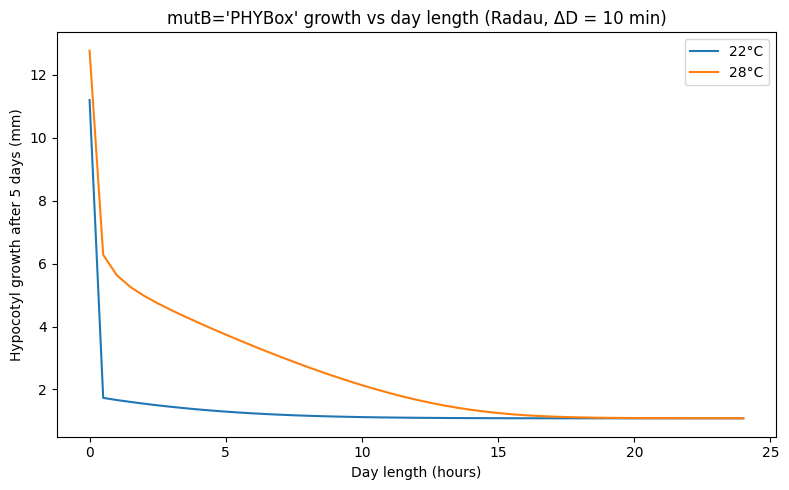

In [14]:
dl_step_h = 30.0/60.0  # 30 min en horas
daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

growth_22 = np.empty_like(daylengths)
growth_28 = np.empty_like(daylengths)

for i, D in enumerate(daylengths):
    _, y22 = simulate_5days(T=22, D=D, dt_minutes=30, mutB='PHYBox')
    _, y28 = simulate_5days(T=28, D=D, dt_minutes=30, mutB='PHYBox')
    growth_22[i] = y22[4, -1]  # G al final (120 h)
    growth_28[i] = y28[4, -1]


# ===========
# Plot figure
# ===========
plt.figure(figsize=(8, 5))
plt.plot(daylengths, growth_22, label="22°C")
plt.plot(daylengths, growth_28, label="28°C")
plt.xlabel("Day length (hours)")
plt.ylabel("Hypocotyl growth after 5 days (mm)")
plt.title("mutB='PHYBox' growth vs day length (Radau, ΔD = 10 min)")
plt.legend()
plt.tight_layout()
plt.show()

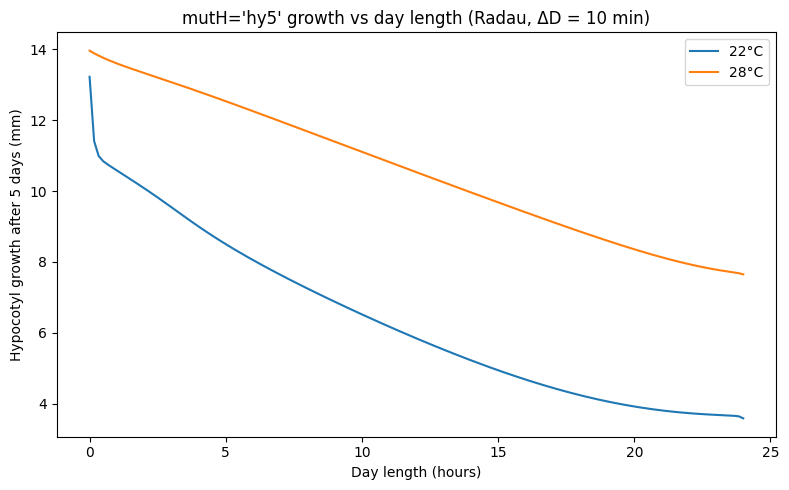

In [15]:
dl_step_h = 10.0/60.0  # 30 min en horas
daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

growth_22 = np.empty_like(daylengths)
growth_28 = np.empty_like(daylengths)

# hy5 mutant
for i, D in enumerate(daylengths):
    _, y22 = simulate_5days(T=22, D=D, dt_minutes=10, mutH='hy5')
    _, y28 = simulate_5days(T=28, D=D, dt_minutes=10, mutH='hy5')
    growth_22[i] = y22[4, -1]  # G al final (120 h)
    growth_28[i] = y28[4, -1]


# ===========
# Plot figure
# ===========
plt.figure(figsize=(8, 5))
plt.plot(daylengths, growth_22, label="22°C")
plt.plot(daylengths, growth_28, label="28°C")
plt.xlabel("Day length (hours)")
plt.ylabel("Hypocotyl growth after 5 days (mm)")
plt.title("mutH='hy5' growth vs day length (Radau, ΔD = 10 min)")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
dl_step_h = 10.0/60.0  # 30 min en horas
#daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)
daylengths = np.linspace(0.0, 24.0, 100)

growth_22 = np.empty_like(daylengths)
growth_28 = np.empty_like(daylengths)

# hy5 mutant
for i, D in enumerate(daylengths):
    _, y22 = simulate_5days(T=22, D=D, dt_minutes=10, mutH='hy5')
    _, y28 = simulate_5days(T=28, D=D, dt_minutes=10, mutH='hy5')
    growth_22[i] = y22[4, -1]  # G al final (120 h)
    growth_28[i] = y28[4, -1]


# ===========
# Plot figure
# ===========
plt.figure(figsize=(8, 5))
plt.plot(daylengths, growth_22, label="22°C")
plt.plot(daylengths, growth_28, label="28°C")
plt.xlabel("Day length (hours)")
plt.ylabel("Hypocotyl growth after 5 days (mm)")
plt.title("mutH='hy5' growth vs day length (Radau, ΔD = 10 min)")
plt.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

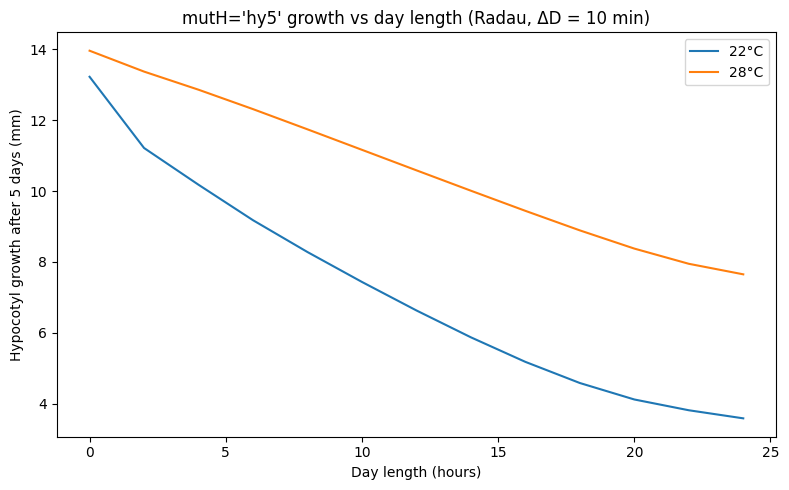

In [ ]:
dl_step_h = 120.0/60.0  # 30 min en horas
daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

growth_22 = np.empty_like(daylengths)
growth_28 = np.empty_like(daylengths)

# hy5 mutant
for i, D in enumerate(daylengths):
    _, y22 = simulate_5days(T=22, D=D, dt_minutes=120, mutH='hy5')
    _, y28 = simulate_5days(T=28, D=D, dt_minutes=120, mutH='hy5')
    growth_22[i] = y22[4, -1]  # G al final (120 h)
    growth_28[i] = y28[4, -1]


# ===========
# Plot figure
# ===========
plt.figure(figsize=(8, 5))
plt.plot(daylengths, growth_22, label="22°C")
plt.plot(daylengths, growth_28, label="28°C")
plt.xlabel("Day length (hours)")
plt.ylabel("Hypocotyl growth after 5 days (mm)")
plt.title("mutH='hy5' growth vs day length (Radau, ΔD = 10 min)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
dl_step_h = 10.0/60.0  # 30 min en horas
daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

growth_22 = np.empty_like(daylengths)
growth_28 = np.empty_like(daylengths)

# hy5 mutant
for i, D in enumerate(daylengths):
    _, y22 = simulate_5days(T=22, D=D, dt_minutes=10, mutH='hy5')
    _, y28 = simulate_5days(T=28, D=D, dt_minutes=10, mutH='hy5')
    growth_22[i] = y22[4, -1]  # G al final (120 h)
    growth_28[i] = y28[4, -1]


# ===========
# Plot figure
# ===========
plt.figure(figsize=(8, 5))
plt.plot(daylengths, growth_22, label="22°C")
plt.plot(daylengths, growth_28, label="28°C")
plt.xlabel("Day length (hours)")
plt.ylabel("Hypocotyl growth after 5 days (mm)")
plt.title("mutH='hy5' growth vs day length (Radau, ΔD = 10 min)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
build_params(T=22, mutH='WT')['mut_H']
build_params(T=22, mutH='hy5')['mut_H']

0.0

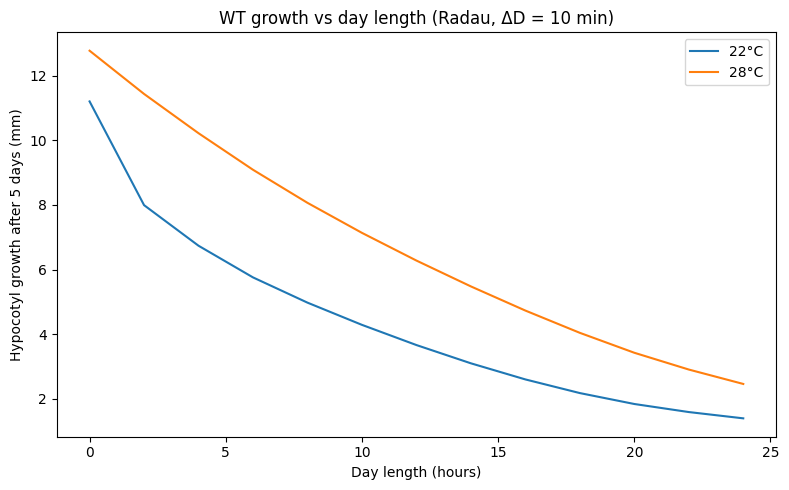

In [ ]:
dl_step_h = 120.0/60.0  # 30 min en horas
daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

growth_22 = np.empty_like(daylengths)
growth_28 = np.empty_like(daylengths)

for i, D in enumerate(daylengths):
    _, y22 = simulate_5days(T=22, D=D, dt_minutes=120)
    _, y28 = simulate_5days(T=28, D=D, dt_minutes=120)
    growth_22[i] = y22[4, -1]  # G al final (120 h)
    growth_28[i] = y28[4, -1]


# ===========
# Plot figure
# ===========
plt.figure(figsize=(8, 5))
plt.plot(daylengths, growth_22, label="22°C")
plt.plot(daylengths, growth_28, label="28°C")
plt.xlabel("Day length (hours)")
plt.ylabel("Hypocotyl growth after 5 days (mm)")
plt.title("WT growth vs day length (Radau, ΔD = 10 min)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# import pandas as pd

# # Example arrays
# array1 = [1, 2, 3]
# array2 = [4, 5, 6]

# # Combine arrays into a DataFrame
# data = pd.DataFrame({'growth_22': growth_22, 'growth_28': growth_28})

# # Export to CSV
# data.to_csv('hy5_mutant_growth_simul.csv', index=True)

In [ ]:
# dl_step_h = 30.0/60.0  # 30 min en horas
# daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

# growth_22 = np.empty_like(daylengths)
# growth_28 = np.empty_like(daylengths)

# for i, D in enumerate(daylengths):
#     _, y22 = simulate_5days(T=22, D=D, dt_minutes=30, mutE='elf3-8')
#     _, y28 = simulate_5days(T=28, D=D, dt_minutes=30, mutE='elf3-8')
#     growth_22[i] = y22[4, -1]  # G al final (120 h)
#     growth_28[i] = y28[4, -1]

# # ===========
# # Plot figure
# # ===========
# plt.figure(figsize=(8, 5))
# plt.plot(daylengths, growth_22, label="22°C")
# plt.plot(daylengths, growth_28, label="28°C")
# plt.xlabel("Day length (hours)")
# plt.ylabel("Hypocotyl growth after 5 days (mm)")
# plt.title("WT growth vs day length (Radau, ΔD = 10 min)")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# dl_step_h = 30.0/60.0  # 30 min en horas
# daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

# growth_22 = np.empty_like(daylengths)
# growth_28 = np.empty_like(daylengths)

# for i, D in enumerate(daylengths):
#     _, y22 = simulate_5days(T=22, D=D, dt_minutes=30, mutE='elf3-8', mutC='cop1-4')
#     _, y28 = simulate_5days(T=28, D=D, dt_minutes=30, mutE='elf3-8', mutC='cop1-4')
#     growth_22[i] = y22[4, -1]  # G al final (120 h)
#     growth_28[i] = y28[4, -1]

# # ===========
# # Plot figure
# # ===========
# plt.figure(figsize=(8, 5))
# plt.plot(daylengths, growth_22, label="22°C")
# plt.plot(daylengths, growth_28, label="28°C")
# plt.xlabel("Day length (hours)")
# plt.ylabel("Hypocotyl growth after 5 days (mm)")
# plt.title("mutE='elf3-8', mutC='cop1-4' growth vs day length (Radau, ΔD = 10 min)")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# dl_step_h = 30.0/60.0  # 30 min en horas
# daylengths = np.arange(0.0, 24.0 + dl_step_h/2, dl_step_h)

# growth_22 = np.empty_like(daylengths)
# growth_28 = np.empty_like(daylengths)

# for i, D in enumerate(daylengths):
#     _, y22 = simulate_5days(T=22, D=D, dt_minutes=30, mutP='PIF4ox')
#     _, y28 = simulate_5days(T=28, D=D, dt_minutes=30, mutP='PIF4ox')
#     growth_22[i] = y22[4, -1]  # G al final (120 h)
#     growth_28[i] = y28[4, -1]

# # ===========
# # Plot figure
# # ===========
# plt.figure(figsize=(8, 5))
# plt.plot(daylengths, growth_22, label="22°C")
# plt.plot(daylengths, growth_28, label="28°C")
# plt.xlabel("Day length (hours)")
# plt.ylabel("Hypocotyl growth after 5 days (mm)")
# plt.title("WT growth vs day length (Radau, ΔD = 10 min)")
# plt.legend()
# plt.tight_layout()
# plt.show()